Identifying Fraudulent Activities Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, et􏰅.

Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

Challenge Description
Company XYZ is an e-commerce site that sells hand-made clothes.
You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").
These are the tasks you are asked to do:

For each user, determine her country based on the numeric IP address.

Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? 

what kind of different user experiences would you build based on the model output?

user_id : Id of the user. Unique by user

signup_time : the time when the user created her account (GMT time)

purchase_time : the time when the user bought the item (GMT time)

purchase_value : the cost of the item purchased (USD)

device_id : the device id. You can assume that it is unique by device. I.e., 􏰄 transa􏰅tions with the same device ID means that the same physical device was used to bu􏰆

source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser).

browser : the browser used by the user.

sex : user sex: Male/Female

age : user age

ip_address : user numeric ip address

class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).

In [187]:
# package

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib as plt


In [791]:
# load data
fraud = pd.read_csv('./data/Fraud_data.csv')

In [792]:
# display data
fraud.head(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [793]:
# unbalanced data
fraud.groupby('class')['class'].count()

class
0    136961
1     14151
Name: class, dtype: int64

In [794]:
# convert purchase_time into purchase_year, purchase_month, purchase_hour, purchase_weekday, purchase_daty
def extract_year(vec):
    return(vec[0:4])
fraud['purchase_year'] = fraud.purchase_time.apply(extract_year)

def extract_month(vec):
    return(vec[5:7])
fraud['purchase_month'] = fraud.purchase_time.apply(extract_month)

def extract_day(vec):
    return(vec[8:10])
fraud['purchase_day'] = fraud.purchase_time.apply(extract_day)

def extract_hour(vec):
    return(vec[11:13])
fraud['purchase_hour'] = fraud.purchase_time.apply(extract_hour)

def extract_fulldate(vec):
    return(vec[0:10])
fraud['purchase_fulldate'] = fraud.purchase_time.apply(extract_fulldate)

def extract_weekday(vec):
    return(datetime.strptime(vec,'%Y-%m-%d').weekday())
fraud['purchase_weekday'] = fraud.purchase_fulldate.apply(extract_weekday)

fraud = fraud.drop('purchase_time', axis=1)
#fraud = fraud.drop('purchase_fulldate', axis = 1)

In [795]:
# convert signup_time into signup_year, signup_month, signup_hour, signup_weekday, signup_day
fraud['signup_year'] = fraud.signup_time.apply(extract_year)
fraud['signup_month'] = fraud.signup_time.apply(extract_month)
fraud['signup_day'] = fraud.signup_time.apply(extract_day)
fraud['signup_hour'] = fraud.signup_time.apply(extract_hour)
fraud['signup_fulldate'] = fraud.signup_time.apply(extract_fulldate)
fraud['signup_weekday'] = fraud.signup_fulldate.apply(extract_weekday)

fraud = fraud.drop('signup_time', axis = 1)


In [796]:
# calculate days between purchase and sign up date
def to_date(vec):
    return(datetime.strptime(vec,'%Y-%m-%d'))
fraud.signup_fulldate = fraud.signup_fulldate.apply(to_date)
fraud.purchase_fulldate = fraud.purchase_fulldate.apply(to_date)

fraud['day_diff'] = None

fraud.day_diff = fraud.purchase_fulldate - fraud.signup_fulldate
def day_diff(vec):
    return(vec.days)
fraud.day_diff = fraud.day_diff.apply(day_diff)

In [797]:
pd.set_option('display.max_columns', 500)
fraud.head()

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_fulldate,purchase_weekday,signup_year,signup_month,signup_day,signup_hour,signup_fulldate,signup_weekday,day_diff
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,2015,04,18,02,2015-04-18,5,2015,02,24,22,2015-02-24,1,53
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,2015,06,08,01,2015-06-08,0,2015,06,07,20,2015-06-07,6,1
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,2015,01,01,18,2015-01-01,3,2015,01,01,18,2015-01-01,3,0
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,2015,05,04,13,2015-05-04,0,2015,04,28,21,2015-04-28,1,6
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,2015,09,09,18,2015-09-09,2,2015,07,21,07,2015-07-21,1,50


In [798]:
# all variables
fraud.columns

Index(['user_id', 'purchase_value', 'device_id', 'source', 'browser', 'sex',
       'age', 'ip_address', 'class', 'purchase_year', 'purchase_month',
       'purchase_day', 'purchase_hour', 'purchase_fulldate',
       'purchase_weekday', 'signup_year', 'signup_month', 'signup_day',
       'signup_hour', 'signup_fulldate', 'signup_weekday', 'day_diff'],
      dtype='object')

In [799]:
# drop unnecessary variables
fraud = fraud.drop('signup_fulldate',axis=1)
fraud = fraud.drop('purchase_fulldate',axis=1)

In [800]:
# every user_id is unique
print(len(fraud.user_id.unique()))
print(fraud.shape[0])

151112
151112


In [801]:
# device ID is not unique
print(len(fraud.device_id.unique()))
print(fraud.device_id.count())

137956
151112


In [802]:
# show repeated device
device_ID = list(fraud.device_id)
def repeat_device(s):
    return(device_ID.count(s))
fraud['repeated_device'] = None
fraud.repeated_device = fraud.device_id.apply(repeat_device)

In [803]:
# drop device_id
fraud = fraud.drop('device_id', axis=1)

In [804]:
# only three types of channel
print(fraud.source.unique())
fraud[fraud['class']==1].groupby('source').count()['class']

['SEO' 'Ads' 'Direct']


source
Ads       5513
Direct    3226
SEO       5412
Name: class, dtype: int64

In [805]:
# convert source into dummy
source_dummy = pd.get_dummies(fraud.source)
fraud = pd.concat([fraud, source_dummy], axis=1, sort=False)
fraud = fraud.drop('source', axis=1)

In [806]:
# browser
print(fraud.groupby('browser').count()['user_id'])
print(fraud[fraud['class']==1].groupby('browser').count()['user_id'])

browser_dummy = pd.get_dummies(fraud.browser)
fraud = pd.concat([fraud, browser_dummy], axis=1, sort=False)

browser
Chrome     61432
FireFox    24610
IE         36727
Opera       3676
Safari     24667
Name: user_id, dtype: int64
browser
Chrome     6069
FireFox    2342
IE         3187
Opera       328
Safari     2225
Name: user_id, dtype: int64


In [807]:
# sex
print(fraud.groupby('sex').count()['user_id'])
print(fraud[fraud['class']==1].groupby('sex').count()['user_id'])

sex_dummy = pd.get_dummies(fraud.sex)
fraud = pd.concat([fraud, sex_dummy], axis=1, sort=False)

sex
F    62819
M    88293
Name: user_id, dtype: int64
sex
F    5717
M    8434
Name: user_id, dtype: int64


In [808]:
# drop sex and browser
fraud = fraud.drop('sex', axis=1)
fraud = fraud.drop('browser', axis=1)

In [264]:
# load IP address
ip = pd.read_csv('./data/IpAddress_to_Country.csv')
print(ip.shape)
ip.head()

(138846, 3)


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [277]:
# convert ip_address to float
ip.lower_bound_ip_address  = ip.lower_bound_ip_address.apply(float)
ip.upper_bound_ip_address  = ip.upper_bound_ip_address.apply(float)

In [346]:
# finding country for each ip address
country  = [None]*fraud.shape[0]
for i in range(0, fraud.shape[0]):
    x = ip.country[(fraud['ip_address'][i] >=  ip['lower_bound_ip_address'])][fraud['ip_address'][i] <= ip['upper_bound_ip_address']]
    x = list(x)
    country[i] = x


In [360]:
# reformatting country
country1  = [None]*fraud.shape[0]
for i in range(0, fraud.shape[0]):
    if country[i] == []:
        country1[i] = 'None'
    else:
        country1[i] = country[i][0]


In [809]:
# adding country into fraud
country2 = pd.DataFrame(country1)
fraud = pd.concat([fraud, country2],axis=1, sort=False)
fraud = fraud.drop('country', axis=1)
fraud.columns = list(fraud.columns[:-1])+['country']

KeyError: "labels ['country'] not contained in axis"

In [ ]:
# drop ip_address
fraud = fraud.drop('ip_address', axis=1)

In [821]:
# country
country_df1 = pd.DataFrame(fraud.country.value_counts())
country_df2 = pd.DataFrame(fraud[fraud['class']==1].country.value_counts())
country_df  = pd.concat([country_df1,country_df2], axis=1, sort=False)
country_df.columns = ['all_country','country_1']
country_df['percent'] = country_df.country_1/country_df.all_country



In [822]:
# list of country with high percentage of fraud transaction 
country_df.sort_values('percent', ascending=False)[country_df['all_country']>=5].head(15)

/Users/wx3land/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,all_country,country_1,percent
Namibia,23,10.0,0.434783
Sri Lanka,31,13.0,0.419355
Luxembourg,72,28.0,0.388889
Ecuador,106,28.0,0.264151
Tunisia,118,31.0,0.262712
Peru,119,31.0,0.260504
Bolivia,53,13.0,0.245283
Kuwait,90,21.0,0.233333
Ireland,240,55.0,0.229167
New Zealand,278,62.0,0.223022


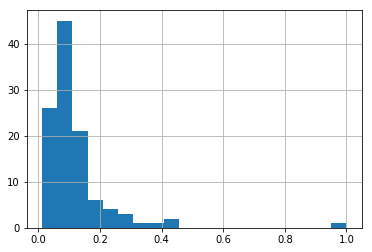

In [823]:
# categorize percent into 6 categories: percent0to5, percent5to10, percent10to15, percent15to20, percent20to30, percent30to100
country_df.percent.hist(bins=20)

def f(val):
    if val <=0.05:
        return('percent0to5')
    elif val <= 0.1:
        return('percent5to10')
    elif val <= 0.15:
        return('percent10to15')
    elif val <= 0.20:
        return('percent15to20')
    elif val <= 0.30:
        return('percent20to30')
    else:
        return('percent30to100')
country_df['country_risk_category'] = country_df.percent.apply(f)

country_df['name'] = country_df.index    

In [824]:
# remove unnecessary columns
fraud = pd.merge(fraud, country_df, left_on='country', right_on='name')
fraud = fraud.drop('all_country',axis=1)
fraud = fraud.drop('country_1',axis=1)
fraud = fraud.drop('country_risk_category',axis=1)
fraud = fraud.drop('name',axis=1)
fraud = fraud.drop('country', axis=1)
fraud = fraud.drop('user_id',axis=1)

In [825]:
# checking NaN
def check_nan(vec):
    return(sum(vec.isnull()))
fraud.apply(check_nan, axis=0)

purchase_value        0
age                   0
ip_address            0
class                 0
purchase_year         0
purchase_month        0
purchase_day          0
purchase_hour         0
purchase_weekday      0
signup_year           0
signup_month          0
signup_day            0
signup_hour           0
signup_weekday        0
day_diff              0
repeated_device       0
Ads                   0
Direct                0
SEO                   0
Chrome                0
FireFox               0
IE                    0
Opera                 0
Safari                0
F                     0
M                     0
percent             517
dtype: int64

In [829]:
# set NaN to -1
fraud['percent'][fraud['percent'].isnull()] = -1


/Users/wx3land/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [869]:
# test, training
from sklearn.model_selection import train_test_split
fraud_x = fraud.drop('class', axis=1)
fraud_y = fraud['class']

X_train, X_test, y_train, y_test = train_test_split(fraud_x, fraud_y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(120889, 26) (120889,)
(30223, 26) (30223,)


In [870]:
from sklearn.utils import resample

X = pd.concat([X_train,pd.DataFrame(y_train)],axis=1)

# Separate majority and minority classes
df_majority = X[X['class']==0]
df_minority = X[X['class']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0])    # to match majority class
 
# Combine majority class with upsampled minority class
X = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
X['class'].value_counts()

1    109609
0    109609
Name: class, dtype: int64

In [871]:
X_train = X.drop('class', axis=1)
y_train = X['class']

In [872]:
# logistic regression
# saga, with max_iter=2000 works well, recall = 0.68, acc = 0.66
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='liblinear',multi_class='ovr', C = 0.0001, class_weight = 'balanced',max_iter=50).fit(X_train, y_train)
logit_pred = clf.predict(X_test)

#logit_pred_prob  = clf.predict_proba(X_test) 

#logit_score = clf.score(X_test, y_test)

In [873]:
print(np.mean(logit_pred[y_test==1] == y_test[y_test==1]))
print(np.mean(logit_pred[y_test==0] == y_test[y_test==0]))
print(np.mean(logit_pred == y_test))

coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(clf.coef_))], axis = 1)


0.0
1.0
0.9050061211659994


In [842]:
coefficients

,0,0
0,purchase_value,1.852104e-20
1,age,4.223861e-20
2,ip_address,-5.472327e-12
3,purchase_year,-2.429147e-32
4,purchase_month,-4.617918e-19
5,purchase_day,-7.960311e-19
6,purchase_hour,1.077256e-20
7,purchase_weekday,2.014066e-20
8,signup_year,-2.429147e-32
9,signup_month,-2.905081e-19


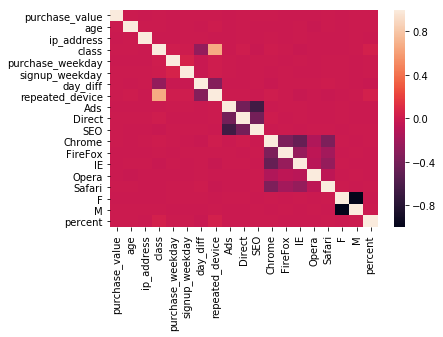

In [843]:
import seaborn as sns
import pandas as pd

#plt.figure(figsize=(40,40)) 
# play with the figsize until the plot is big enough to plot all the columns
# of your dataset, or the way you desire it to look like otherwise

sns.heatmap(fraud.corr())

In [844]:
# ridge
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(class_weight='balanced',normalize=True,alpha=1, max_iter = 1000).fit(X_train, y_train)

ridge_pred = clf.predict(X_test)

clf.score(X_train, y_train) 

clf.get_params(deep=True)

clf.coef_

array([[ 7.01113696e-05,  2.43213618e-04, -3.58122063e-12,
         0.00000000e+00, -2.50524349e-02, -6.57087334e-03,
         2.97599988e-05,  3.18367816e-03,  0.00000000e+00,
        -2.50816507e-02, -6.41382376e-03,  2.66154816e-04,
         1.42391616e-03, -2.01362789e-03,  3.86064257e-02,
        -5.70600269e-03,  3.33222211e-02, -1.77591546e-02,
         5.60692130e-03,  3.16025652e-03, -8.87107041e-03,
         4.98163382e-04, -1.61759605e-03, -7.03290269e-03,
         7.03290269e-03,  4.24928282e-01]])

In [845]:
print(np.mean(ridge_pred[y_test==1] == y_test[y_test==1]))
print(np.mean(ridge_pred[y_test==0] == y_test[y_test==0]))
print(np.mean(ridge_pred == y_test))

0.5841863748676315
0.9146403797006206
0.8836647586275354


In [874]:
# random forest
# n_estimators=100,max_depth = 6, max_features=7, recall = 0.7, acc = 0.92
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150,max_depth = 3, max_features=7,
                             min_samples_split = 100)
clf.fit(X_train, y_train)

print(clf.feature_importances_)
rf_pred = clf.predict(X_test)

[5.15694646e-05 1.59321615e-04 1.33105468e-04 0.00000000e+00
 1.90138763e-01 4.03149120e-02 4.50160007e-05 5.47260484e-04
 0.00000000e+00 1.18439410e-01 2.97610113e-02 8.19871101e-05
 1.86492530e-03 2.19800740e-01 3.95238071e-01 1.09587747e-04
 1.21327011e-03 7.16762143e-05 2.75888808e-06 8.04577131e-06
 2.09481742e-06 1.82587370e-06 1.58315447e-05 1.10601826e-05
 2.44089278e-06 1.98531441e-03]


In [875]:
print(np.mean(rf_pred[y_test==1] == y_test[y_test==1]))
print(np.mean(rf_pred[y_test==0] == y_test[y_test==0]))
print(np.mean(rf_pred == y_test))

0.7171717171717171
0.9332772740567418
0.9127485689706515


In [876]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27352
           1       0.53      0.72      0.61      2871

   micro avg       0.91      0.91      0.91     30223
   macro avg       0.75      0.83      0.78     30223
weighted avg       0.93      0.91      0.92     30223



In [877]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, rf_pred)

array([[25527,  1825],
       [  812,  2059]])

In [878]:
#fraud.to_csv('fraud_processed.csv',index=False)

In [879]:
rf_pred_prob = clf.predict_proba(X_test)
rf_pred_threshold = [None]*len(rf_pred_prob)
for i in range(0,len(rf_pred_prob)):
    if rf_pred_prob[i,1] > 0.6:
        rf_pred_threshold[i] = 1
    else:
        rf_pred_threshold[i] = 0
print(confusion_matrix(y_test, rf_pred_threshold))
print(classification_report(y_test, rf_pred_threshold))

[[27185   167]
 [ 1286  1585]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     27352
           1       0.90      0.55      0.69      2871

   micro avg       0.95      0.95      0.95     30223
   macro avg       0.93      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223



In [880]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
repeated_device,0.395238
day_diff,0.219801
purchase_month,0.190139
signup_month,0.118439
purchase_day,0.040315
signup_day,0.029761
percent,0.001985
signup_weekday,0.001865
Direct,0.001213
purchase_weekday,0.000547


In [886]:
# rerun RF with fewer variables
variables = ['repeated_device','day_diff','purchase_month','signup_month','purchase_day',
             'signup_day','percent','signup_weekday','Direct','purchase_weekday','age',
             'Ads','purchase_value','class']
fraud_rf = fraud[variables]

In [888]:
fraud_rf.head()

,repeated_device,day_diff,purchase_month,signup_month,purchase_day,signup_day,percent,signup_weekday,Direct,purchase_weekday,age,Ads,purchase_value,class
0,1,53,04,02,18,24,0.097865,1,0,5,39,0,34,0
1,1,69,04,02,23,13,0.097865,4,1,3,32,0,72,0
2,1,8,08,08,24,16,0.097865,6,1,0,44,0,52,0
3,1,35,08,07,07,03,0.097865,4,0,4,36,1,22,0
4,2,76,07,05,18,03,0.097865,6,0,5,37,0,32,0


In [889]:
# test, training
from sklearn.model_selection import train_test_split
fraud_rf_x = fraud_rf.drop('class', axis=1)
fraud_rf_y = fraud_rf['class']

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(fraud_rf_x, fraud_rf_y, test_size=0.2)
print(X_train_rf.shape, y_train_rf.shape)
print(X_test_rf.shape, y_test_rf.shape)



(120889, 13) (120889,)
(30223, 13) (30223,)


In [890]:
from sklearn.utils import resample

X_rf = pd.concat([X_train_rf,pd.DataFrame(y_train_rf)],axis=1)

# Separate majority and minority classes
df_majority = X_rf[X_rf['class']==0]
df_minority = X_rf[X_rf['class']==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0])    # to match majority class
 
# Combine majority class with upsampled minority class
X_rf = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
X_rf['class'].value_counts()

1    109635
0    109635
Name: class, dtype: int64

In [891]:
X_train_rf = X_rf.drop('class', axis=1)
y_train_rf = X_rf['class']

In [919]:
# random forest
# n_estimators=100,max_depth = 6, max_features=7, recall = 0.7, acc = 0.92
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=150,max_depth = 10, max_features=3,
                             min_samples_split = 100)
clf.fit(X_train_rf, y_train_rf)

rf1_pred = clf.predict(X_test_rf)

In [920]:
print(np.mean(rf1_pred[y_test_rf==1] == y_test_rf[y_test_rf==1]))
print(np.mean(rf1_pred[y_test_rf==0] == y_test_rf[y_test_rf==0]))
print(np.mean(rf1_pred == y_test_rf))

0.7069382119433897
0.938922637780868
0.9166859676405387


In [921]:
from sklearn.metrics import classification_report
print(classification_report(y_test_rf, rf1_pred))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27326
           1       0.55      0.71      0.62      2897

   micro avg       0.92      0.92      0.92     30223
   macro avg       0.76      0.82      0.79     30223
weighted avg       0.93      0.92      0.92     30223



In [922]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_rf, rf1_pred)

array([[25657,  1669],
       [  849,  2048]])

In [918]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train_rf.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
repeated_device,0.403558
day_diff,0.198546
purchase_month,0.163365
signup_month,0.109327
signup_day,0.048834
purchase_day,0.039097
percent,0.008484
signup_weekday,0.007037
purchase_weekday,0.006724
purchase_value,0.005991


In [935]:
# threshold
rf1_pred_prob = clf.predict_proba(X_test_rf)
rf1_pred_threshold = [None]*len(rf1_pred_prob)
for i in range(0,len(rf_pred_prob)):
    if rf1_pred_prob[i,1] > 0.57:
        rf1_pred_threshold[i] = 1
    else:
        rf1_pred_threshold[i] = 0
print(confusion_matrix(y_test_rf, rf1_pred_threshold))
print(classification_report(y_test_rf, rf1_pred_threshold))

[[25679  1647]
 [  858  2039]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27326
           1       0.55      0.70      0.62      2897

   micro avg       0.92      0.92      0.92     30223
   macro avg       0.76      0.82      0.79     30223
weighted avg       0.93      0.92      0.92     30223



# EDA

In [1020]:
# EDA - January has the most fraud by percent
a = pd.DataFrame(fraud[fraud['class'] == 1].groupby('purchase_month').count()['class'])
b = pd.DataFrame(fraud.groupby('purchase_month').count()['class'])
c = pd.concat([a,b], axis = 1)
c['percent'] = a/b
c

,class,class,percent
purchase_month,,,
01,7723,10097,0.764881
02,291,6449,0.045123
03,545,12090,0.045079
04,740,16551,0.044710
05,921,19364,0.047562
06,842,18908,0.044531
07,900,19507,0.046137
08,833,18662,0.044636
09,663,14347,0.046212


<IPython.core.display.Javascript object>


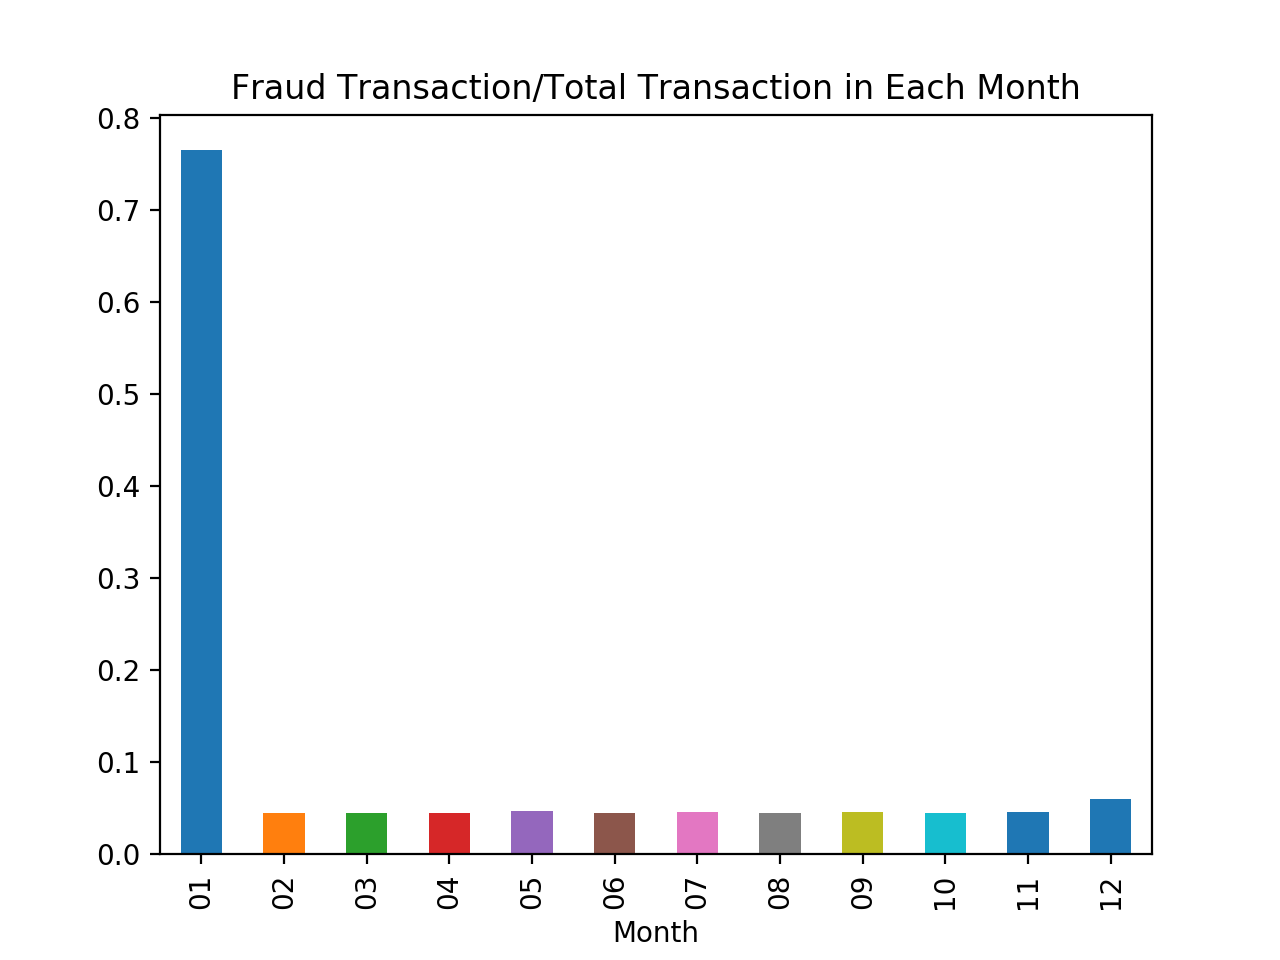

Text(0.5,0,'Month')

In [1021]:
c.percent.plot.bar()
plt.title('Fraud Transaction/Total Transaction in Each Month')
plt.xlabel('Month')

In [1022]:
# EDA - Thursday and Saturday tend to have more fraud
a = pd.DataFrame(fraud[fraud['class'] == 1].groupby('purchase_weekday').count()['class'])
b = pd.DataFrame(fraud.groupby('purchase_weekday').count()['class'])
c = pd.concat([a,b], axis = 1)
c['percent'] = a/b
c

,class,class,percent
purchase_weekday,,,
0,2089,21711,0.096219
1,1669,21314,0.078305
2,1711,21316,0.080268
3,2119,21586,0.098165
4,2192,21522,0.101849
5,2149,21648,0.099270
6,2222,22015,0.100931


<IPython.core.display.Javascript object>


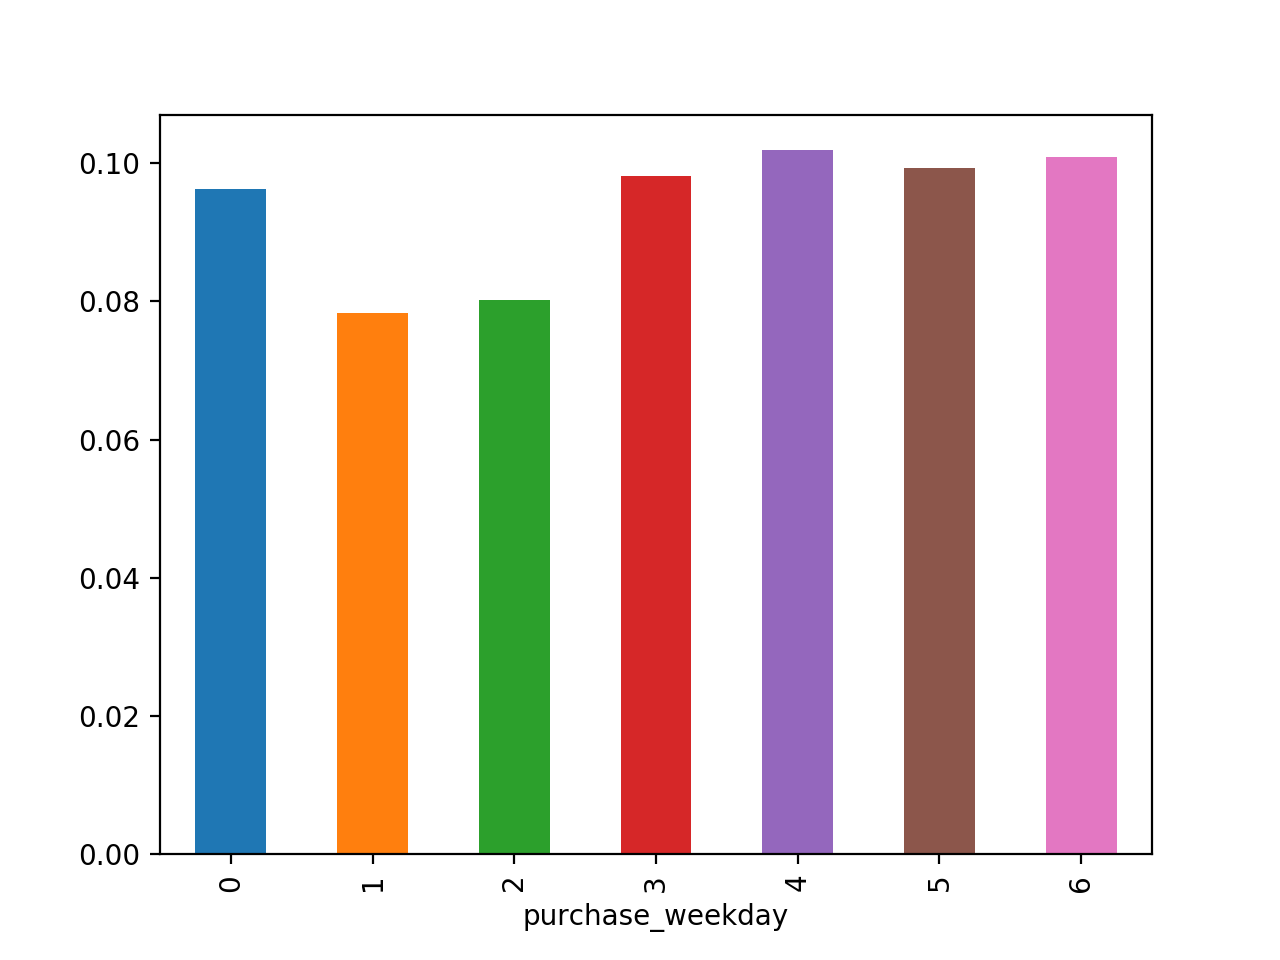

In [1023]:
c.percent.plot.bar()
# the fraud transactions in monday and tuesday are noticebly lower

<IPython.core.display.Javascript object>


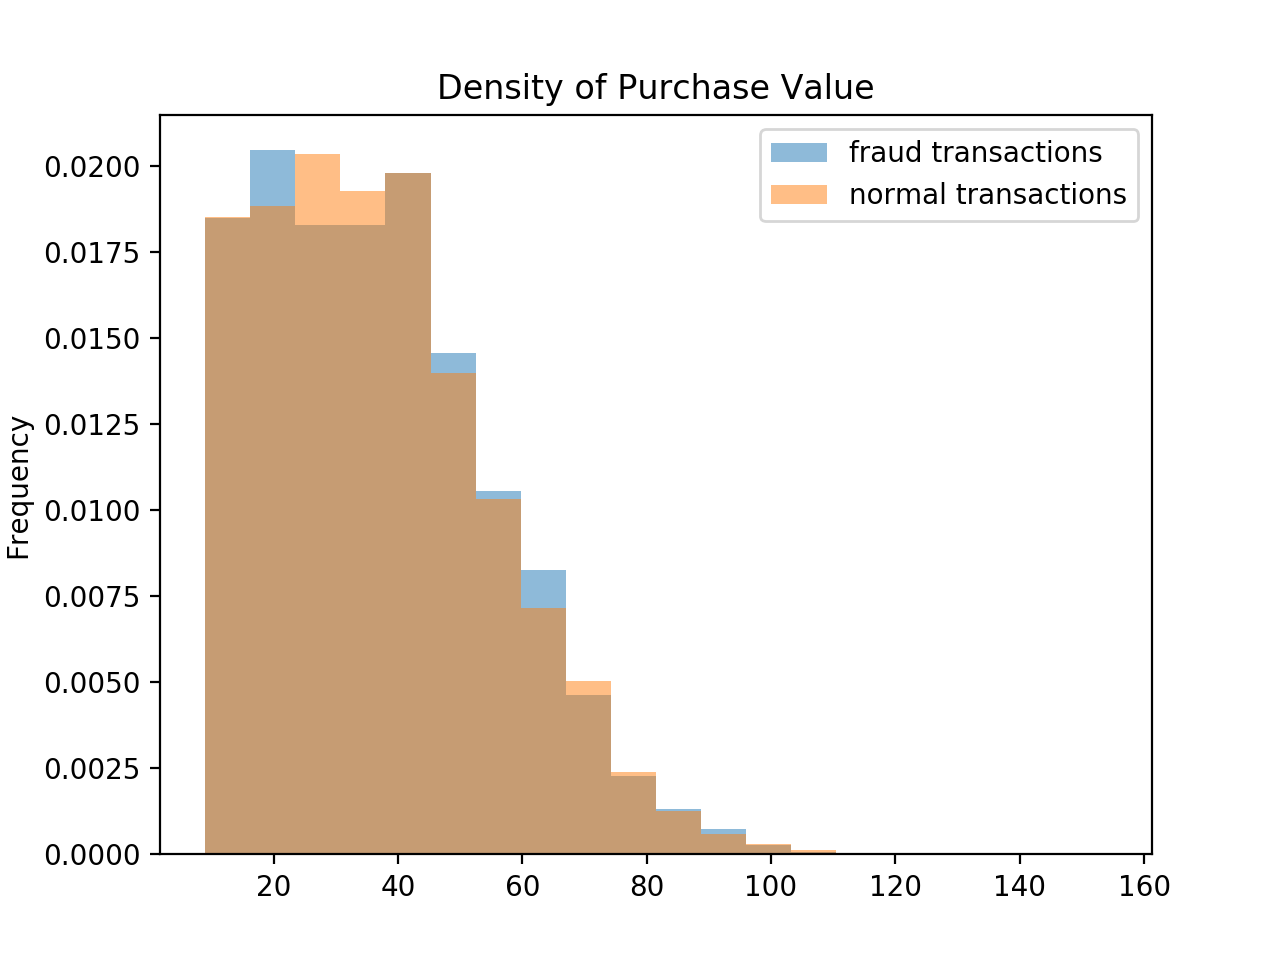

Text(0.5,1,'Density of Purchase Value')

In [1052]:
# Price of fraud transaction and normal transaction - no major difference
a = pd.DataFrame(fraud['purchase_value'][fraud['class']==1])
b = pd.DataFrame(fraud['purchase_value'][fraud['class']==0])
c = pd.concat([a,b], axis=1, sort=False)
c.columns = ['fraud transactions','normal transactions']
c.plot.hist( density=True,alpha=0.5, bins=20)
plt.title('Density of Purchase Value')

/Users/wx3land/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/wx3land/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/wx3land/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/Users/wx3land/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<IPython.core.display.Javascript object>


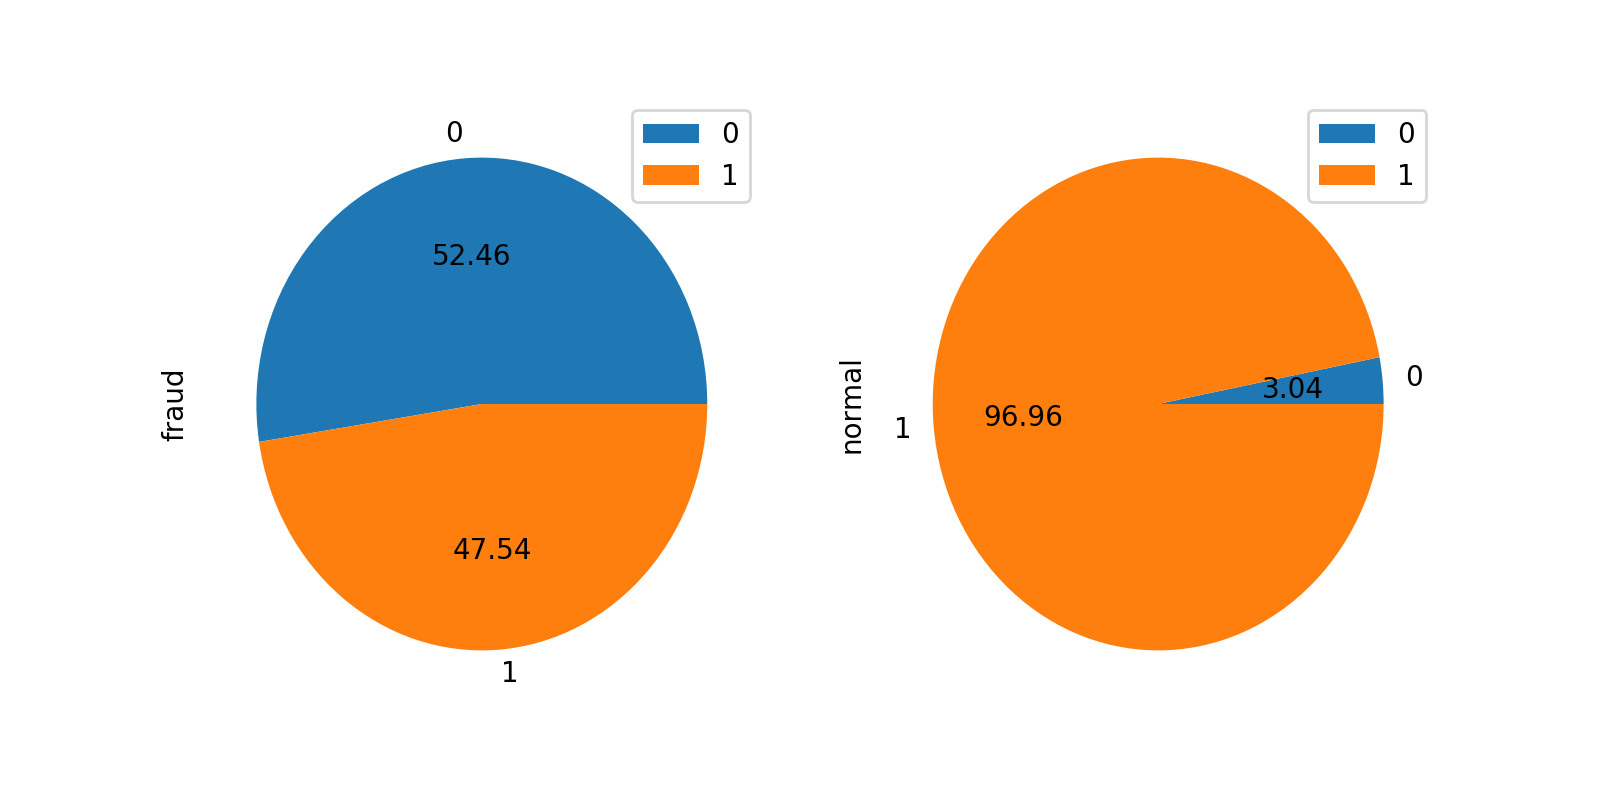

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c3b1ab780>,
      dtype=object)

In [1079]:
# repeat  device - majority of fraud transactions are made by repeated device
a = np.array([[fraud[fraud['class']==1][fraud['repeated_device']>=2].count()[0],
             fraud[fraud['class']==1][fraud['repeated_device']<2].count()[0]],
             [fraud[fraud['class']==0][fraud['repeated_device']>=2].count()[0],
             fraud[fraud['class']==0][fraud['repeated_device']<2].count()[0]]]
            )
a = pd.DataFrame(a)
a.columns = ['fraud','normal']
a.plot.pie(subplots=True, figsize=(8,4),autopct='%.2f', fontsize=10)

<IPython.core.display.Javascript object>


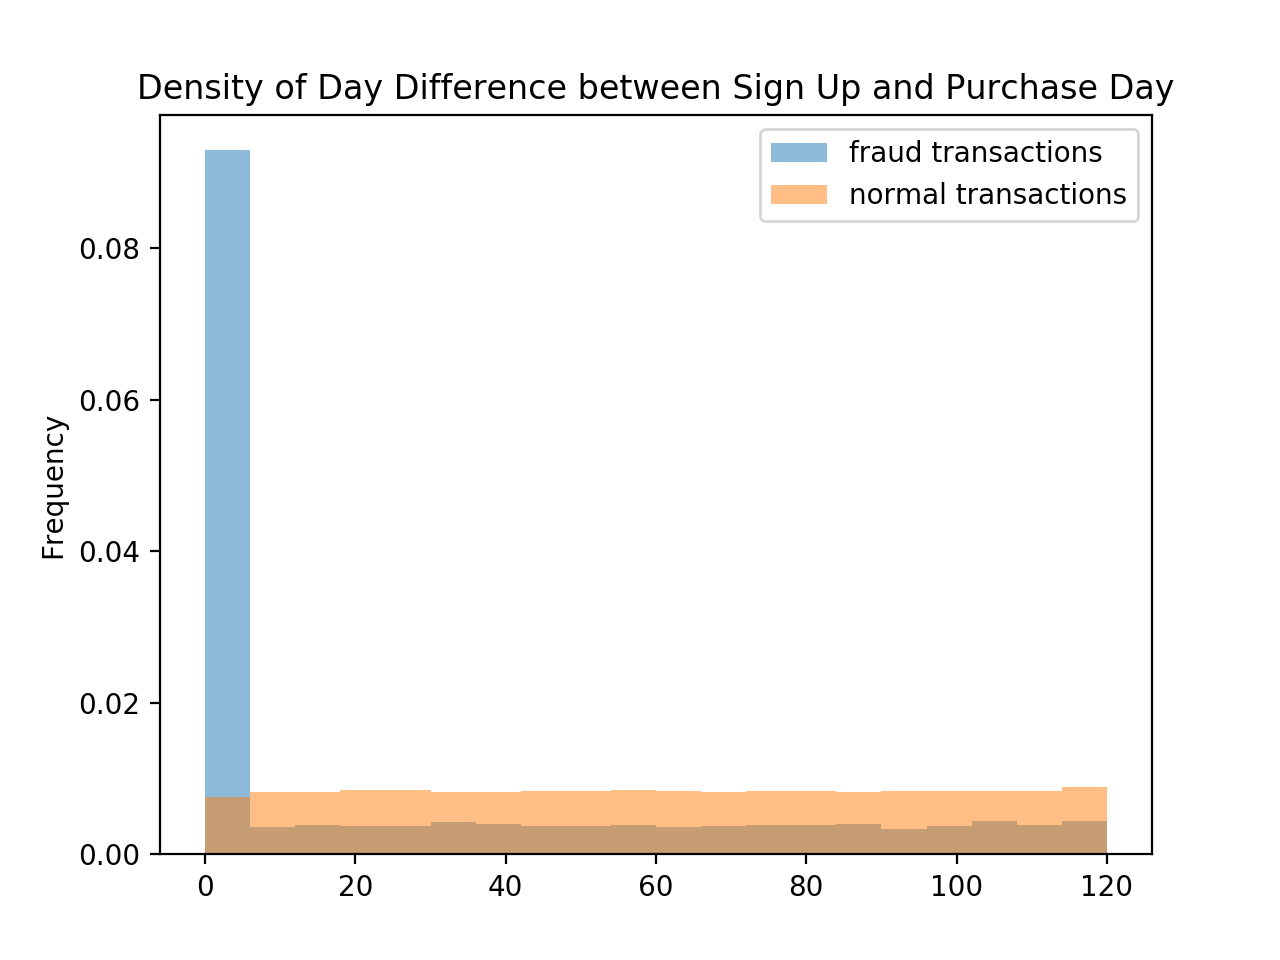

Text(0.5,1,'Density of Day Difference between Sign Up and Purchase Day')

In [1082]:
# Day Difference between Sign Up and Purchase Day
# fraud transactions tend to make purchase on the day of sign up
a = pd.DataFrame(fraud['day_diff'][fraud['class']==1])
b = pd.DataFrame(fraud['day_diff'][fraud['class']==0])
c = pd.concat([a,b], axis=1, sort=False)
c.columns = ['fraud transactions','normal transactions']
c.plot.hist( density=True,alpha=0.5, bins=20)
plt.title('Density of Day Difference between Sign Up and Purchase Day')